In [2]:
import numpy as np
from ASDShCom_Ripoll import *
import matplotlib.pyplot as plt
from multiprocessing import Pool

%config InlineBackend.figure_format = 'svg'
plt.rcParams.update({'font.size': 18})

In [3]:
# physical/mathematical constants
c = 3e8
hbar = 1e-34
pi = np.pi

readout_rate = lambda tRT, T : -0.5/tRT*np.log(1-T) # tRT: round-trip time, T: transmission

# squeezer parameter standard (high)
xRatio0 = 0.95

# Zhang2021 loss standard: T_loss_a, T_loss_b, T_loss_c, Rpd
losses0 = (100e-6, 1000e-6, 1000e-6, 0.1)

# readout standards: phiPump, psi0, psi1, psi2
pumpPhi0 = pi/2
signalRO = pumpPhi0, pi/2, pumpPhi0, 0 # phiPump and psi1 are arbitrary
idlerRO = pumpPhi0, pi/2, pumpPhi0, pi/2 # psi0 is arbitrary

class IFO(object):
    def __init__(self, lambda0, L_arm, L_SRC, P_circ, T_ITM, T_SRM, M, ws=None, gbR=None, gcR=None):
        """
        
        if gbR and gcR specified, then ws must be as well
        """
        # interferometer parameters, see below for L_SRC and T_ITM
        self.lambda0 = lambda0
        self.L_arm = L_arm
        self.P_circ = P_circ
        self.T_SRM = T_SRM
        self.M = M
        
        # derived parameters
        self.w0 = 2*pi*c/self.lambda0
        self.B = sqrt(self.P_circ*self.L_arm*self.w0/(hbar*c))
        self.mu = self.M/4
        self.rho = (sqrt(2)*((self.B**2)*((self.L_arm**-2.)*hbar)))/self.mu
        self.tRT_arm = 2*self.L_arm/c

        # optional direct definition of ws, gbR, gcR
        # fixing T_SRM=0.046 and changing T_ITM and L_SRC
        if gbR is None and gcR is None:
            self.L_SRC = L_SRC 
            self.tRT_SRC = 2*self.L_SRC/c
            self.gbR = readout_rate(self.tRT_SRC,self.T_SRM)
            # default to signal-idler symmetric at SRM
            self.gcR = self.gbR
        elif gbR is None:
            # e.g. for setting gcR = 0 (closing idler port)
            self.L_SRC = L_SRC 
            self.tRT_SRC = 2*self.L_SRC/c
            self.gbR = readout_rate(self.tRT_SRC,self.T_SRM)
            self.gcR = gcR
        elif gcR is None:
            # sim. for closing signal port
            self.L_SRC = L_SRC 
            self.tRT_SRC = 2*self.L_SRC/c
            self.gcR = readout_rate(self.tRT_SRC,self.T_SRM)
            self.gbR = gbR
        else: 
            self.gbR = gbR
            self.gcR = gcR
            if self.gbR == 0:
                self.tRT_SRC = -0.5/self.gcR*np.log(1-self.T_SRM)
            else:
                self.tRT_SRC = -0.5/self.gbR*np.log(1-self.T_SRM)
            # if both specified, then L_SRC is inferred from T_SRM
            self.L_SRC = c*self.tRT_SRC/2

        if ws is not None: 
            self.ws = ws
            self.T_ITM = (2*self.ws/c)**2*self.L_arm*self.L_SRC # Titm inferred from ws
        else:
            self.T_ITM = T_ITM
            self.ws = 0.5*(c*(sqrt(((self.T_ITM/self.L_SRC)/self.L_arm))))            

    def print_params(self):
        """Titm and Lsrc will be inferred from ws, gbR, gcR if the latter are specified"""
        print("""lambda0={:.3e}m,
L_arm={:.1f}km,
L_SRC={:.1f}m,
P_circ={:.1e}W,
T_ITM={:.3f},
T_SRM={:.3f},
M={}kg,
ws/(2pi)={:.3f}kHz,
gbR/(2pi)={:.3f}kHz,
gcR/(2pi)={:.3f}kHz""".format(
            self.lambda0, self.L_arm*1e-3, self.L_SRC, self.P_circ, self.T_ITM, self.T_SRM, self.M,
              self.ws/(2*pi)*1e-3, self.gbR/(2*pi)*1e-3, self.gcR/(2*pi)*1e-3))

    def ga_fn(self, T_loss_a): return readout_rate(self.tRT_arm,T_loss_a)
    def gbtot_fn(self, T_loss_b): return self.gbR + readout_rate(self.tRT_SRC,T_loss_b)
    def gctot_fn(self, T_loss_c): return self.gcR + readout_rate(self.tRT_SRC,T_loss_c)
        
    def singularity_thr(self, T_loss_a, T_loss_b, T_loss_c):
        # ((W0, x0), (W1, x1))
        ga = self.ga_fn(T_loss_a)
        gbtot = self.gbtot_fn(T_loss_b)
        gctot = self.gctot_fn(T_loss_c)

        # poleSol = np.array([[0,sqrt((gctot*(gbtot+((self.ws**2)/ga))))],[sqrt(((((gctot*(self.ws**2))-(ga*(self.ws**2)))-((ga**2)*(gbtot+gctot)))/(gbtot+\gctot))),sqrt(((ga+gbtot)*(ga+(gctot+((self.ws**2)/(gbtot+gctot))))))]])
        if T_loss_a != 0:
            thr = min(sqrt((gctot*(gbtot+((self.ws**2)/ga)))),
                      sqrt(((ga+gbtot)*(ga+(gctot+((self.ws**2)/(gbtot+gctot)))))))
        else: 
            thr = sqrt(((ga+gbtot)*(ga+(gctot+((self.ws**2)/(gbtot+gctot))))))
        return thr
    
    def singularity_thr_2(self, ga, gbtot, gctot):
        """like singularity_thr but if ga, gbtot, gctot already known"""
        if ga != 0:
            thr = min(sqrt((gctot*(gbtot+((self.ws**2)/ga)))),
                      sqrt(((ga+gbtot)*(ga+(gctot+((self.ws**2)/(gbtot+gctot)))))))
        else: 
            thr = sqrt(((ga+gbtot)*(ga+(gctot+((self.ws**2)/(gbtot+gctot))))))
        return thr
    
    def ASDSh(self, f, xRatio, T_loss_a, T_loss_b, T_loss_c, Rpd, phiPump, psi0, psi1, psi2, radiation_pressure_on=True):
        """combined readout with full freedom, ASD of NSR, using fn from mathematica"""
        ga = self.ga_fn(T_loss_a)
        gbtot = self.gbtot_fn(T_loss_b)
        gctot = self.gctot_fn(T_loss_c)
        x = xRatio*self.singularity_thr_2(ga, gbtot, gctot)
        
        if radiation_pressure_on:
            rho = self.rho
        else:
            rho = 0
        
        NSR = ASDShCom(2*pi*f, self.B, self.ws, x, ga, gbtot, self.gbR, gctot, self.gcR, phiPump, psi0, psi1, psi2, rho, Rpd)
        #if NSR.imag > 1e-30:
        #    raise ValueError("significant imaginary component")
        #else:
        #    return NSR.real
        return NSR.real
        
    def plot_vs_freq(self, paramsList, freq_tuple, labels=None, save_path=None, show_fig=True):
        """plot sensitivity vs frequency in parallel for different parameters,
        paramsList is a list of lists of arguments to ASDSh,
        freq_tuple=(fmin,fmax,fnum),
        labels is a list of legend labels finished by the legend title"""
        f_List = np.logspace(np.log10(freq_tuple[0]),np.log10(freq_tuple[1]),num=freq_tuple[2])
        #results = np.zeros((len(paramsList),len(f_List)))
        plt.rcParams.update({'font.size': 18})
        fig, ax = plt.subplots(figsize=(6,4))
        if labels is None:
            labels = [str(i) for i in range(len(paramsList))]
            legend_title = 'index'
        else:
            legend_title = labels[-1]

        for i, params in enumerate(paramsList):  
            global sens_given_params # allows pickling
            def sens_given_params(f):
                return self.ASDSh(f,*params)

            pool = Pool() # check whether restarting the pool results in any speedup
            #results[i] = pool.map(sens_given_params, f_List)
            ax.loglog(f_List, pool.map(sens_given_params, f_List), label=labels[i])

        ax.set_xlabel('frequency / Hz')
        ax.set_ylabel('sensitivity / $\mathrm{Hz}^{-1/2}$')
        ax.legend(title=legend_title)
        if save_path is not None:
            fig.savefig(save_path, bbox_inches = "tight")        
        if show_fig:
            plt.show()
        plt.close(fig)

    def point_log_sens_given_angles(self, psi_angles, *params):
        """returns log10 of ASD of NSR to avoid underflow when optimising,
        psi_angles is a list of [psi0, psi1, psi2] to optimise over,
        params is fixed values of [f (the point), xRatio, T_loss_a, T_loss_b, T_loss_c, Rpd, phiPump]"""
        return np.log10(self.ASDSh(*params, *psi_angles))        

In [4]:
# IFO(lambda0, L_arm, L_SRC, P_circ, T_ITM, T_SRM, M, ws=None, gbR=None, gcR=None)
# aLIGO = IFO(1064e-9, 4e3, 56, 750e3, 0.014, 0.325, 40, None, None, 0)
# aLIGO.print_params()

liIFO = IFO(2e-6, 4e3, None, 3e6, None, 0.046, 200, 2*pi*5000, 2*pi*500, 0)
# liIFO.print_params()

liIFO.plot_vs_freq([
    [0,0,0,0,0,0,pi/2,0,0],
    [0.95,0,0,0,0,0,pi/2,0,0],
    [1,0,0,0,0,0,pi/2,0,0]],(1,1e5,100),("off", "on", "thr", "lossless"), 'li2020_sigRO.pdf', False)

In [5]:
# recovering idler variational readout
ifo = IFO(2e-6, 4e3, None, 3e6, None, 0.046, 200, 2*pi*5000, 0, 2*pi*500)

phiPump_List = np.array([1,2,4,6,7])*pi/8

ifo.plot_vs_freq([[xRatio0,*losses0,phiPump,pi/2,pi/2,pi/2] for phiPump in phiPump_List],
                 (1,1e4,100),
                 np.concatenate((
                     ['{:g}$\pi/8$'.format((pi/2-phiPump)*8/pi) for phiPump in phiPump_List],
                     ['$\psi_1-\phi$'])), 'idlerRO_variational.pdf', False)

In [6]:
# optimal filter for integrated sensitivity 
ifo = IFO(2e-6, 4e3, None, 3e6, None, 0.046, 200, 2*pi*5000, 2*pi*500, 2*pi*5)

num_samples = 100
freq_range = (50, 3e3) #(5, 2e4)
freq_List = np.logspace(np.log10(freq_range[0]),np.log10(freq_range[1]),num=num_samples)

# adjust losses here, make sure to update file tag to not overwrite existing results
losses1 = losses0 #(75e-6, 1000e-6, 100e-6, 0.1) #(*losses0[:-1], 0) #(0,0,0,0) #losses0
max_iter = 10
file_tag = 'realistic_losses_global_optim_maxiter={}'.format(max_iter)

# recover signal and idler comparison (manually for incoh)
def fn0(f):
    return ifo.ASDSh(f,xRatio0,*losses1,*signalRO) # cannot pickle lambdas

def fn1(f):
    return ifo.ASDSh(f,xRatio0,*losses1,*idlerRO)

# parallel plotting
pool = Pool()
res0_signal = pool.map(fn0, freq_List)
res1_idler = pool.map(fn1, freq_List)
# incoherently combined readout
incoh = np.minimum(res0_signal,res1_idler)

In [57]:
# hack: optim angles at each point in sample, check cty later, maybe curvefit?
# creates angles.npy
pumpPhi0 = pi/2
bounds0 = ((0,2*pi),(0,2*pi),(0,2*pi))

# # local minimization
# from scipy.optimize import minimize
# global min_given_freq
# def min_given_freq(freq):
#     args0 = (freq, xRatio0, *losses1, pumpPhi0)
#     result = minimize(ifo.point_log_sens_given_angles, np.random.uniform(0, 2*pi, 3), args=args0, bounds=bounds0)
#     return result.x
# optim_fn = min_given_freq

# global minimization
from scipy.optimize import dual_annealing
global global_min_given_freq
def global_min_given_freq(freq):
    args0 = (freq, xRatio0, *losses1, pumpPhi0)
    result = dual_annealing(ifo.point_log_sens_given_angles, bounds=bounds0, args=args0, maxiter=max_iter)
    return result.x
optim_fn = global_min_given_freq

# import tqdm
# angles_List = np.array(list(tqdm.tqdm(pool.imap_unordered(min_given_freq, freq_List), total=num_samples)))
pool = Pool()
angles_List = np.array(pool.map(optim_fn, freq_List))

save_path = './optimal_angles/angles_{}.npy'.format(file_tag)
np.save(save_path, angles_List)
# import os.path
# for i in range(10):
#     path = 'angles_{}.npy'.format(i)
#     if not os.path.exists(path):
#         np.save(path, angles_List)
#         break
# else:
#     print("no available path")

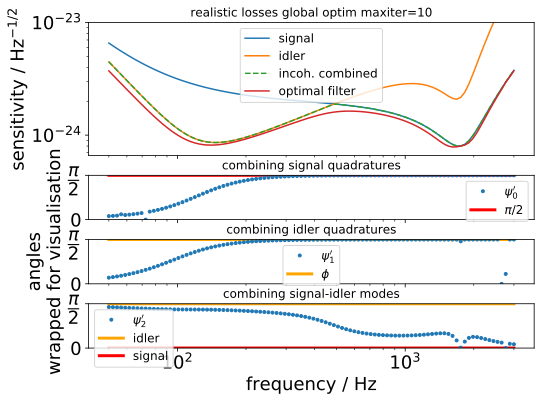

In [7]:
load_path = './optimal_angles/angles_{}.npy'.format(file_tag)
save_path = 'optimal_filter_{}.pdf'.format(file_tag)
plot_title = file_tag.replace('_',' ')

# plot sig, idler, incoh, and optimal together
# change path to current angles
angles_List = np.load(load_path)

fig, axs = plt.subplots(4, 1, figsize=(8,6), sharex=True, gridspec_kw={'height_ratios': [3, 1, 1, 1]})
plt.subplots_adjust(hspace=0.3)

axs[1].plot(freq_List, np.ones_like(freq_List)*pi/2, 'r', linewidth=3, label='$\pi/2$')
axs[1].plot(freq_List, np.ones_like(freq_List)*pi*3/2, 'r', linewidth=3)
axs[2].plot(freq_List, np.ones_like(freq_List)*pi/2, color='orange', linewidth=3, label='$\phi$')
axs[2].plot(freq_List, np.ones_like(freq_List)*pi*3/2, color='orange', linewidth=3)
axs[3].plot(freq_List, np.transpose(np.array([np.full_like(freq_List,t) for t in (0,pi,2*pi)])), 'r', linewidth=3, label='signal')
axs[3].plot(freq_List, np.transpose(np.array([np.full_like(freq_List,t) for t in (pi/2,3/2*pi)])), linewidth=3, color='orange', label='idler')

# axs[0].plot(freq_List, angles_List[:,0] % (pi), '.', label='$\psi_0$')
# axs[1].plot(freq_List, angles_List[:,1] % (pi), '.', label='$\psi_1$')
# axs[2].plot(freq_List, angles_List[:,2] % (pi), '.', label='$\psi_2$')
# axs[1].set_ylabel('readout angle mod $\pi$')
wrapped_angles_List = np.empty_like(angles_List)
wrapped_angles_List[:,0] = angles_List[:,0] % (pi/2)
wrapped_angles_List[:,1] = angles_List[:,1] % (pi/2)
wrapped_angles_List[:,2] = pi/2 - abs((angles_List[:,2] % pi) - pi/2)
axs[1].plot(freq_List, wrapped_angles_List[:,0], '.', label="$\psi_0'$")
axs[2].plot(freq_List, wrapped_angles_List[:,1], '.', label="$\psi_1'$")
axs[3].plot(freq_List, wrapped_angles_List[:,2], '.', label="$\psi_2'$")
axs[2].set_ylabel('angles\nwrapped for visualisation')
# axs[1].yaxis.set_label_coords(-0.05,1.05)
# axs[2].set_ylabel('angle s-i folded')
# axs[2].yaxis.set_label_coords(-0.1,0.5)
# axs[0].plot(freq_List, angles_List[:,0], '.', label='$\psi_0$')
# axs[1].plot(freq_List, angles_List[:,1], '.', label='$\psi_1$')
# axs[2].plot(freq_List, angles_List[:,2], '.', label='$\psi_2$')
# axs[1].set_ylabel('readout angle')
for i in range(1, len(axs)):
    axs[i].set_yticks(np.linspace(0,pi,3))
    axs[i].set_yticklabels(['0','$\dfrac{\pi}{2}$','$\pi$'])
#     axs[i].set_ylim(0, pi)
    axs[i].set_ylim(0, pi/2)
#     axs[i].set_yticks(np.linspace(0,2*pi,3))
#     axs[i].set_yticklabels(['0','$\pi$','$2\pi$'])
#     axs[i].set_ylim(0, 2*pi)    
    axs[i].set_xscale('log')
    axs[i].legend(fontsize=12)   
    # remove duplicate labels
    handles, labels = axs[i].get_legend_handles_labels()
    by_label = dict(zip(labels[::-1], handles[::-1]))
    axs[i].legend(by_label.values(), by_label.keys(), fontsize=12)
axs[1].set_title('combining signal quadratures', fontsize=12)
axs[2].set_title('combining idler quadratures', fontsize=12)
axs[3].set_title('combining signal-idler modes', fontsize=12)
axs[0].set_title(plot_title, fontsize=12)
    
axs[0].loglog(freq_List, res0_signal, label='signal')
axs[0].loglog(freq_List, res1_idler, label='idler')
axs[0].loglog(freq_List, incoh, '--', label='incoh. combined')

# use hack results
params0 = (xRatio0, *losses1, pumpPhi0)

def psi(i, f):
    return angles_List[np.searchsorted(freq_List, f), i]

def sens_w_variationalRO(f):
    return ifo.ASDSh(f, *params0, psi(0, f), psi(1, f), psi(2, f))

pool = Pool() 
axs[0].loglog(freq_List, pool.map(sens_w_variationalRO, freq_List), '-', label='optimal filter')
axs[3].set_xlabel('frequency / Hz')
axs[0].set_ylabel('sensitivity / $\mathrm{Hz}^{-1/2}$')
axs[0].set_ylim(None, 1e-23)
axs[0].legend(fontsize=12) #bbox_to_anchor=(2, 0.5)

plt.rcParams.update({'font.size': 12})
plt.show()
fig.savefig(save_path, bbox_inches = "tight")
plt.close(fig)

In [ ]:
# compile ASDSh? http://numba.pydata.org/numba-doc/0.17.0/user/jit.html
# @jit(nopython=True, cache=True)

# Google's python cloud cores?

In [ ]:
# global angles for integrated sensitivity, using log to avoid underflow
ifo = IFO(2e-6, 4e3, None, 3e6, None, 0.046, 200, 2*pi*5000, 2*pi*500, 2*pi*5)

import scipy.integrate as integrate

def minus_log_integrated_sens_given_angles(psi_angles, *params):
    """returns -log10 of integrated 1/(ASD of NSR) to avoid underflow when minimising,
    psi_angles is a list of [psi0, psi1, psi2] to optimise over,
    params is fixed values of [xRatio, T_loss_a, T_loss_b, T_loss_c, Rpd, phiPump]"""
    
    integral_bounds = (0, np.infty)
    #integral_bounds = (1e0, 1e5) # beyond the bucket
    
    integral, err = integrate.quad(lambda f : 1/ifo.ASDSh(f, *params, *psi_angles), *integral_bounds)
    
    return -np.log10(integral)

args0 = (xRatio0, *losses0, pumpPhi0)
bounds0 = ((0,2*pi),(0,2*pi),(0,2*pi))

print(
    minus_log_integrated_sens_given_angles(signalRO[1:], *args0),
    minus_log_integrated_sens_given_angles(idlerRO[1:], *args0))

# # local minimization --> TOO SLOW!
# from scipy.optimize import minimize

# result = minimize(minus_log_integrated_sens_given_angles, np.random.uniform(0, 2*pi, 3),
#                   args=args0, bounds=bounds0, options={'maxiter': 3})
# print(result.fun, result.x)

# # from scipy.optimize import dual_annealing
# # result = dual_annealing(log_integrated_sens_given_angles, bounds=bounds0, args=args0, maxiter=10)
# # print(result)